# import 函式庫

In [1]:
import json
import pandas as pd
import gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import random
from collections import deque
from gym import spaces

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
import csv
import os
import re
import numpy as np
import copy
import warnings
# import seaborn as sns

# 環境參數

In [2]:
# 環境參數
running_time = 282
# 超參數
EPISODES = 1000
EPS_START = 0.9  # 隨機選擇行動的概率
EPS_END = 0
EPS_DECAY = EPISODES*0.25  # epsilon 衰減的速度
GAMMA = 0.98  # 折扣因子
LR = 0.001  # 學習率
MEMORY_SIZE = 10000  # 經驗回放的記憶體大小
BATCH_SIZE = 128  # 訓練批次的大小

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 自訂函式

In [3]:
# # 讀取Raw資料
def loadCsvFileToDict(filename, ueid):
    # 读取CSV文件
    data = pd.read_csv(filename)

    headers = data.columns.tolist()
    # print("headers in cell csv = ",headers)

    data_dict = {header: [] for header in headers}

    if ueid != 'null':
        if isinstance(ueid, list):
            ueid_rows = data[data['UeID'].isin(ueid)].reset_index(drop=True)
        else:
            ueid_rows = data[data['UeID'] == ueid].reset_index(drop=True)
    else:
        ueid_rows = data
    
    for _, row in ueid_rows.iterrows():
        for header, value in row.items():
            if str(value).isdigit():
                data_dict[header].append(int(value))
            elif re.match(r'^[-+]?\d*\.?\d*$', str(value)):
                data_dict[header].append(float(value))
            elif re.match(r'^S.*$', str(value)):
                # print(value)
                data_dict[header].append(int(value[1]))
            # else :
            #     print(row)
            #     print("loadCsvFileToDict have an unknown value : ", value)

    # Access the processed data
    # for header, values in data_dict.items():
    #     print(header, values)

    #print("example to show clown [Viavi.Geo.x] = ",data['Viavi.Geo.x'])
    print("load " + filename + " successed")
    print("************")
    return data_dict

In [4]:
# label handover的資料
def handoverDetect(Timestamp, ServingCellId):
    print("****** function: handoverDetect ******")
    merged_list = [Timestamp, ServingCellId]

    # 创建与原始列表相同的副本列表
    handover_list = copy.deepcopy(merged_list)
    # 计算新副本列表中的每个元素与原始列表中前一个元素的差值
    for i in range(1, len(handover_list[1])):
        if(merged_list[1][i] == merged_list[1][i-1]) :
            handover_list[1][i] = 0
        else :
            handover_list[1][i] = 1
    handover_list[1][0] = 0
    handover_dict = {
        "Timestamp" : handover_list[0],
        "Handover" : handover_list[1],
    }
    
    print("handover label finish")
    print("************")
    return handover_dict

In [5]:
# Raw資料轉換，擷取time、cell_ID、cell_RSRP資料
def PrepareInput(ue_data):
    print("****** function: PrepareInput ******")
    unmerge_data = {
        "Timestamp" : ue_data['Timestamp'],
        "ServingCellId": ue_data['ServingCellId'],
        "ServingCellRsrp": ue_data['ServingCellRsrp'],
        #"ServingCellRsSinr": ue_data['ServingCellRsSinr'],
        "neighbourCell1": ue_data['neighbourCell1'],
        "neighbourCell1Rsrp": ue_data['neighbourCell1Rsrp'],
        #"neighbourCell1RsSinr": ue_data['neighbourCell1RsSinr'],
        "neighbourCell2": ue_data['neighbourCell2'],
        "neighbourCell2Rsrp": ue_data['neighbourCell2Rsrp'],
        #"neighbourCell2RsSinr": ue_data['neighbourCell2RsSinr'],
        "neighbourCell3": ue_data['neighbourCell3'],
        "neighbourCell3Rsrp": ue_data['neighbourCell3Rsrp'],
        #"neighbourCell3RsSinr": ue_data['neighbourCell3RsSinr'],
        "neighbourCell4": ue_data['neighbourCell4'],
        "neighbourCell4Rsrp": ue_data['neighbourCell4Rsrp'],
        #"neighbourCell4RsSinr": ue_data['neighbourCell4RsSinr'],
        "neighbourCell5": ue_data['neighbourCell5'],
        "neighbourCell5Rsrp": ue_data['neighbourCell5Rsrp'],
        #"neighbourCell5RsSinr": ue_data['neighbourCell5RsSinr'],
    }
    unmerge_data_list = list(unmerge_data.items())
    # print(unmerge_data_list)
    # print(unmerge_data_list[1][0])
    # print(unmerge_data_list[1][1])
    # print(unmerge_data_list[1][1][1])
    serving_cell_id = unmerge_data_list[1][1]

    time = unmerge_data_list[0][1]
    cell_id = np.zeros((4000, 6))
    cell_id_index = [1,3,5,7,9,11]
    cell_rsrp = np.zeros((4000, 6))


    for time in range (len(time)):
        serving_id_temp = unmerge_data_list[1][1][time]
        cell_id[time][serving_id_temp - 1] = 1
        
        for cell_num in cell_id_index:
            cell_num_temp = unmerge_data_list[cell_num][1][time]
            cell_rsrp[time][cell_num_temp - 1] = unmerge_data_list[cell_num + 1][1][time]
            
    # print(cell_id)

    # 處理重複點
    zero_points = np.argwhere(cell_rsrp == 0)
    # print(zero_points)
    for zero_points_index in range(len(zero_points)-2):
        time = zero_points[zero_points_index][0]
        cell = zero_points[zero_points_index][1]
        # 前兩點的插值
        last_two_point_diff = cell_rsrp[time-2][cell] - cell_rsrp[time-1][cell]
        consider_last_two_point = cell_rsrp[time-1][cell] - last_two_point_diff
        # 後兩點的插值
        future_two_point_diff = cell_rsrp[time+2][cell] - cell_rsrp[time+1][cell]
        consider_future_two_point = cell_rsrp[time+1][cell] - future_two_point_diff
        # 隔壁鄰居的數值 12
        avg_neighbor = sum(cell_rsrp[time])/5
        if(abs(avg_neighbor - consider_last_two_point) < 12):
            cell_rsrp[time][cell] = consider_last_two_point
        if(abs(avg_neighbor - consider_future_two_point) < 12):
            cell_rsrp[time][cell] = consider_future_two_point
    
    print("************")
    return time, cell_id, cell_rsrp, serving_cell_id

In [6]:
# 取得基站的放置位置
def getGnbLocation(cell_data):
    print("****** function: getGnbLocation ******")
    cell_x = cell_data["Viavi.Geo.x"]
    cell_y = cell_data["Viavi.Geo.y"]
    cell_ngi = cell_data["Viavi.NrPci"]
    # 去除重复的点
    gnb_location_temp = list(set(zip(cell_x, cell_y, cell_ngi)))
    # 输出去重后的点
    # print(gnb_location)
    gnb_location = [list(t) for t in gnb_location_temp]
    
    print("successfully get gnb location")
    print("************")
    return gnb_location

# 主程式

In [7]:
# input資料擷取
ue_csv_file = 'output_ue.csv'
ue_data = loadCsvFileToDict(ue_csv_file, 1)
handover_label = handoverDetect(ue_data['Timestamp'], ue_data['ServingCellId'])
time, cell_id, cell_rsrp, serving_cell_id = PrepareInput(ue_data)

load output_ue.csv successed
************
****** function: handoverDetect ******
handover label finish
************
****** function: PrepareInput ******
************


In [8]:
# state資料處理?
normalized_cell_rsrp = cell_rsrp / np.linalg.norm(cell_rsrp, axis=1, keepdims=True)
state_data = cell_rsrp
# state_data = normalized_cell_rsrp
print(len(state_data))
print(len(state_data[0]))
print(state_data[0])

4000
6
[ -98.7893619   -93.9443622   -91.02302551  -97.4130493   -99.00097273
 -101.6212523 ]


### DQN 與 DDQN agent

In [9]:
# 自訂環境
class CustomEnv(gym.Env):
    def __init__(self, time=running_time, num_cells=6, state_data=state_data):
        super(CustomEnv, self).__init__()
        
        self.time = time
        self.num_cells = num_cells
        self.state_data = state_data
        self.handover_num = 0
        self.unhandover_stack = 0
        self.tol_reward = 0

        self.action_space = spaces.Discrete(num_cells)
        self.observation_space = spaces.Discrete(num_cells)
        
        # Initialize state
        self.state = state_data[0]

        # Initialize the map (Randomly for this example, you can replace this with your own logic)
        self.map = state_data[:time]

    def step(self, action, timestamps, last_action):
                
        rsrp_values = self.state
        action = int(action)
        # print("action = ", action)
        selected_value = rsrp_values[action]
        prb_tot_dl_value = self.get_prb_tot_dl_value(action)  # Get the RRU.PrbTotDl value for the selected action
        

        # reward
        if (last_action == action) : 
            unhandover_reward = self.calculate_unhandover_reward()
            state_reward = selected_value - np.max(rsrp_values) + unhandover_reward - prb_tot_dl_value  # Subtract the PrbTotDl value from the reward
            # print(state_reward)
            self.tol_reward = self.tol_reward + state_reward
        else :
            handover_cost = self.calculate_handover_cost()  # Calculate the cost based on the frequency of handovers
            state_reward = selected_value - np.max(rsrp_values) - handover_cost - prb_tot_dl_value  # Subtract the PrbTotDl value and the handover cost from the reward
            # print(state_reward)
            self.tol_reward = self.tol_reward + state_reward
            self.handover_num = self.handover_num + 1
        # print("handover_num = ", self.handover_num)
        # print("state_reward = ", state_reward)
        # Move to the next point
        if timestamps + 1 < self.time:
            next_point_idx = timestamps + 1
            next_state = self.map[next_point_idx]
            # print(next_state)
        else:  # End of the map
            next_point_idx = timestamps
            next_state = self.state  # Remain at the current point

        self.state = next_state

        done = bool(next_point_idx == self.time-1)

        return self.state, self.tol_reward, done, self.handover_num
    
    def calculate_unhandover_reward(self):
        # rise at x = 10, and slowly decrease to zero when x = 60
        self.unhandover_stack = self.unhandover_stack + 1
        reward_decay = 5*self.unhandover_stack * np.exp(-1. * self.unhandover_stack / 10)
        # print(reward_decay)
        return reward_decay
        # reward_decay = np.exp(-1. * self.unhandover_stack / 5)
        # self.unhandover_stack = self.unhandover_stack + reward_decay
        # return self.unhandover_stack

    def calculate_handover_cost(self):
    # The cost of handovers is simply the number of handovers.
    # We add 1 to the handover number to ensure that the first handover also has a cost.
        # return 2 ** (self.handover_num + 1)
        self.unhandover_stack = 0
        return 20
    
    def get_prb_tot_dl_value(self, action):
    # This function should return the RRU.PrbTotDl value for the given action.
    # You need to implement this function based on your data structure.
        return 0    

    def reset(self):
        # Set the state to the first point
        self.handover_num = 0
        self.unhandover_stack = 0
        self.tol_reward = 0
        self.state = self.map[0]
        return self.state

    def render(self, mode='human'):
        # 環境的渲染，這裡簡單地打印出當前步數
        print(f"Current reward: {self.tol_reward}")


In [10]:
# model
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(6, 96)
        self.fc2 = nn.Linear(96, 192)
        self.fc3 = nn.Linear(192, 6)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [11]:
# ddqn agent
class DoubleDQNAgent:
    def __init__(self):
        self.model = DQN().to(device)
        self.target_model = DQN().to(device)
        self.update_target_model()
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.optimizer = optim.Adam(self.model.parameters(), LR)
        self.steps_done = 0
        self.random_num = 0
        self.greedy_num = 0

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        model_state = Variable(state.cpu()).unsqueeze(0) # 將state以CPU計算
        
        eps_threshold = EPS_END + (EPS_START - EPS_END) * \
            np.exp(-1. * self.steps_done / EPS_DECAY)    # end + (start - end)*e^-(t/EPS_DECAY)
        # 找出3個最大的RSRP所對應的state
        state_temp = state[0]
        top_two_indices = sorted(range(len(state_temp)), key=lambda i:  state_temp[i], reverse=True)[:3]
        # print(top_two_indices)

        # random
        if np.random.rand() <= eps_threshold:
            action_value = self.target_model.forward(model_state.to(device)) 
            action = random.choice(top_two_indices)
            self.random_num = self.random_num + 1
            # print("top_two_indices = ", top_two_indices)

        # greedy 
        else:
            action_value = self.target_model.forward(model_state.to(device))  # 注意將 model_state 轉移到 GPU
            # print("action_value = ", action_value)
            top_indices = torch.topk(action_value, k=1)[1].flatten()
            top_indices_np = top_indices.cpu().numpy()
            action = top_indices_np[0]
            self.greedy_num = self.greedy_num + 1
        # print("action in act", action)
        return action

    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        batch = random.sample(self.memory, BATCH_SIZE)
        for state, action, reward, next_state, done in batch:
            state = Variable(state).to(device)
            next_state = Variable(next_state).to(device)
            reward = torch.from_numpy(np.array([reward], dtype=np.float32)).unsqueeze(0).to(device)
            done = torch.from_numpy(np.array([done], dtype=np.int32)).unsqueeze(0).to(device)

            q_values = self.model(state)
            next_q_values = self.model(next_state)
            next_q_state_values = self.target_model(next_state)

            q_value = q_values.gather(1, torch.LongTensor([[action]]).to(device))
            next_q_value = next_q_state_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1))
            expected_q_value = reward + GAMMA * next_q_value * (1 - done)

            loss = nn.MSELoss()(q_value, expected_q_value.detach())

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
    def reset(self):
        print("greedy_num = ", self.greedy_num)
        self.greedy_num = 0
        print("random_num = ", self.random_num)
        self.random_num = 0
        self.steps_done += 1
        
    def predict_act(self, state):
        # model_state = Variable(state.cpu()).unsqueeze(0)
        # action_value = self.model.forward(model_state.to(device))  # model_state 放到 GPU
        action_value = self.target_model.forward(state)  # model_state 放到 GPU
        print("action_value = ", action_value)
        top_indices = torch.topk(action_value, k=1)[1].flatten()
        # print("top_indices = ", top_indices)
        top_indices_np = top_indices.cpu().numpy()
        action = top_indices_np[0]
        return action

### 開始訓練

In [12]:
# 引入環境
env = CustomEnv()
agent = DoubleDQNAgent() # 模型預設放入GPU執行

# 環境參數
running_time = 282

In [13]:
# 開始訓練
for e in range(EPISODES):
    
    # 初始化參數s
    state = env.reset()
    last_point = serving_cell_id[0]
    total_reward = 0
    action_history = []
    # print(type(state))  
    # print(state)  
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device) # state放入GPU
    # print(state) 
    
    # 訓練流程
    for time_t in range(running_time):
        
        action = agent.act(state)
        # print(action)
        action_history.append(action + 1) # 紀錄每次action
        next_state, reward, done, handover_time = env.step(action, time_t, last_point)
        next_state = torch.from_numpy(next_state).float().unsqueeze(0).to(device) # next_state放入GPU
        agent.memorize(state, action, reward, next_state, done)
        state = next_state
        
        last_point = action # 紀錄上次action

        agent.replay()
        if done or (reward < -500):
            reward = reward - 100
            print(f"結束於 {time_t+1} 秒，於第 {e+1} 輪, handover time = {handover_time}, reward = {reward}")
            agent.reset()
            break
    print(action_history)
    
    # 更新model
    if e % 5 == 0:
        agent.update_target_model()
        print("update model")

In [14]:
# 儲存model 參數
torch.save(agent.model.state_dict(), 'ddqn_model_weights_epsiode_target_v1.pth')

# inference

In [15]:
# inference predict function
def predict_act(agent_inference, state):
        action_value = agent_inference.forward(state)  # state 放到 NN 裡
        top_indices = torch.topk(action_value, k=1)[1].flatten() # 從6個ouput中找最大值
        top_indices_np = top_indices.numpy()    # 轉成numpy
        action = top_indices_np[0]
        return action

In [16]:
# 開始Inference

# 載入NN及權重
agent_inference = DQN()
agent_inference.load_state_dict(torch.load('ddqn_model_weights_epsiode1000_-500_v2.pth')) 

# 區域變數
action_store = [[0] for _ in range(9)]
time_store = [[0] for _ in range(9)]
handover_store = [[0] for _ in range(9)]
serving_cell = [[0] for _ in range(9)]
cell_one_round = [282, 184, 264, 184, 180, 115, 184, 184, 174]

# Inference
for ue_num in range(0,9) :
    # 讀取CSV資料
    ue_data_temp = loadCsvFileToDict(ue_csv_file, ue_num + 1) # cell id 由1到9
    time_store[ue_num], _, cell_rsrp_temp, serving_cell[ue_num] = PrepareInput(ue_data_temp)
    # init
    action_store[ue_num][0] = serving_cell[ue_num][0]

    # 開始預測
    for i in range(len(cell_rsrp_temp[:cell_one_round[ue_num]])):
        state = cell_rsrp_temp[i]
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        # predicted_action = agent_inference.forward(state) 
        predicted_action = predict_act(agent_inference, state)
        if(i ==0):
            print("init state = ", predicted_action)
        action_store[ue_num].append(predicted_action + 1)

    print(f"ue {ue_num + 1} finish predict")
    
    # 顯示結果
    handover_store[ue_num] = handoverDetect(time_store[ue_num], action_store[ue_num])
    print(f"ue {ue_num + 1} model handover          =  {handover_store[ue_num]['Handover']}")
    print(f"ue {ue_num + 1} model action            =  {action_store[ue_num]}")
    print(f"ue {ue_num + 1} original serving_cell   =  {serving_cell[ue_num][:cell_one_round[ue_num]]}")
    
    print("handover seconds             = ", np.nonzero(handover_store[ue_num]['Handover']))


load output_ue.csv successed
************
****** function: PrepareInput ******
************
init state =  2
ue 1 finish predict
****** function: handoverDetect ******
handover label finish
************
ue 1 model handover          =  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### 畫圖

In [17]:
# load csv data
ue_csv_file = 'output_ue.csv'
cell_csv_file = 'cells_05_15.csv'
# 指定ue_id
ue_location = []

for ue_id in range(1,10):
    ue_data = loadCsvFileToDict(ue_csv_file, ue_id)
    # print("ue_data timestamps= ", len(ue_data['Timestamp']))
    # print("ue_data columns = ", len(ue_data))
    # 9*3*4000的list
    handover_label = handoverDetect(ue_data['Timestamp'], ue_data['ServingCellId'])
    ue_location.append([ue_data['Timestamp'], ue_data['X'], ue_data['Y'], handover_label['Handover']])

cell_data = loadCsvFileToDict(cell_csv_file, 'null')
cell_location = getGnbLocation(cell_data)

load output_ue.csv successed
************
****** function: handoverDetect ******
handover label finish
************
load output_ue.csv successed
************
****** function: handoverDetect ******
handover label finish
************
load output_ue.csv successed
************
****** function: handoverDetect ******
handover label finish
************
load output_ue.csv successed
************
****** function: handoverDetect ******
handover label finish
************
load output_ue.csv successed
************
****** function: handoverDetect ******
handover label finish
************
load output_ue.csv successed
************
****** function: handoverDetect ******
handover label finish
************
load output_ue.csv successed
************
****** function: handoverDetect ******
handover label finish
************
load output_ue.csv successed
************
****** function: handoverDetect ******
handover label finish
************
load output_ue.csv successed
************
****** function: handoverDetec

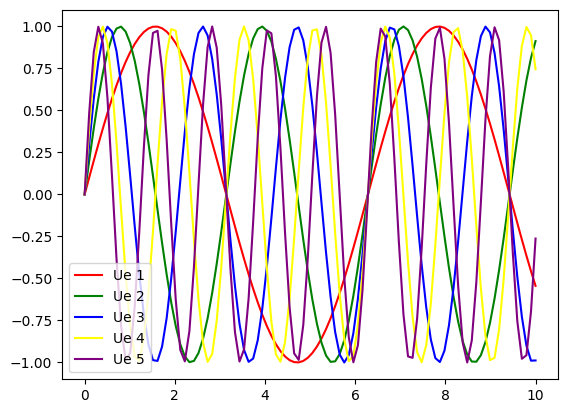

In [18]:
# 定义颜色映射
color_map = {1: 'red', 2: 'green', 3: 'blue', 4: 'yellow', 5: 'purple'}

for ue_num in range(1, 6):
    # 根据ue编号选择颜色
    color = color_map[ue_num]

    # 生成假的x, y数据
    x = np.linspace(0, 10, 100)
    y = np.sin(ue_num * x)

    # 使用指定的颜色绘图
    line, = plt.plot(x, y, color=color, label=f'Ue {ue_num}')

plt.legend()
plt.show()


In [26]:

from IPython.display import clear_output

# DisplayPicture class
class DisplayPicture:
    def __init__(self, cell_one_round, cell_location):
        # external parameter
        self.cell_location = cell_location
        
        # class generate
        self.fig, self.ax = plt.subplots(figsize=(12, 6))
        self.picture_num = 0

    def picture_setting(self):
        self.ax.set_xlabel('X')
        self.ax.set_ylabel('Y')

        # 設定x軸和y軸範圍
        self.ax.set_xlim(-500, 1100)
        self.ax.set_ylim(-600, 250)

        # 設定x軸和y軸格線間隔
        self.ax.set_xticks(np.arange(-500, 1100, 500))
        self.ax.set_yticks(np.arange(-600, 250, 200))

    def plot_cell(self):
        for point in self.cell_location:
            cell_x = point[0] 
            cell_y = point[1]
            self.ax.scatter(cell_x, cell_y, color='red')
            circle = Circle((cell_x, cell_y), 100, edgecolor='red', facecolor='none')
            self.ax.add_patch(circle)

    def display_part_and_save(self):
        clear_output(wait=True)
        
        self.picture_num = self.picture_num + 1
        self.addition_label()

        plt.grid()
        plt.show()
        # 設定檔名、位置，並儲存
        file_name = f"plot_picture{self.picture_num}.png"
        file_path = os.path.join("picture", file_name)
        self.fig.savefig(file_path, dpi=300)
        # 清除圖片
        # time.sleep(0.1)
    
    def pre_display_data(self, ue_num, handover_data, x, y, cell_one_round, color_map, first_time):
        color = color_map[ue_num]
        if first_time:
            line, = self.ax.plot(x, y, color=color, label=f'Ue {ue_num}')
        else:
            line, = self.ax.plot(x, y, color=color)
        self.ax.scatter(x[0], y[0], color=line.get_color())  # 加入起始點
        # 添加handover label點
        for j in range(cell_one_round):
            if handover_data[j] == 1:
                self.ax.scatter(x[j], y[j], color='orange', marker='x', s=100)
            if handover_store[ue_num-1]['Handover'][j] == 1 and j > 2: # ue從1開始到9，所以要-1
                self.ax.scatter(x[j], y[j], facecolors='none', edgecolors='blue', marker='o', s=100)
        
    def addition_label(self):
        legend_elements = [
            Line2D([0], [0], marker='x', color='orange', label='Handover', markerfacecolor='orange', markersize=10, linestyle='None'),
            Line2D([0], [0], marker='o', color='blue', label='model Handover', markerfacecolor='none', markersize=10, linestyle='None'),
        ]
        existing_handles, existing_labels = self.ax.get_legend_handles_labels()
        legend_elements += existing_handles
        labels = ['Handover', 'model Handover'] + existing_labels

        self.ax.legend(handles=legend_elements, labels=labels)
        
    def parameter_reset(self):
        self.picture_num = 0


In [20]:
# Sub_DisplayPicture class
class Sub_DisplayPicture:
    def __init__(self, ue_location):
        self.ue_location = ue_location
        
    def divide_percent(self, x, precent):
        subset = []
        # 使用for循环按照百分比precent%进行分割
        for percentage in range(1, precent+1, 1):
            subset.append(int(x * percentage / precent))
        return subset

    def find_ue_location(self, ue_num, data_num):
        x = []
        y = []
        handover = []
        for k in range(data_num):
            x.append(ue_location[ue_num][1][k])
            y.append(ue_location[ue_num][2][k])
            handover.append(ue_location[ue_num][3][k])
        
        return x, y, handover

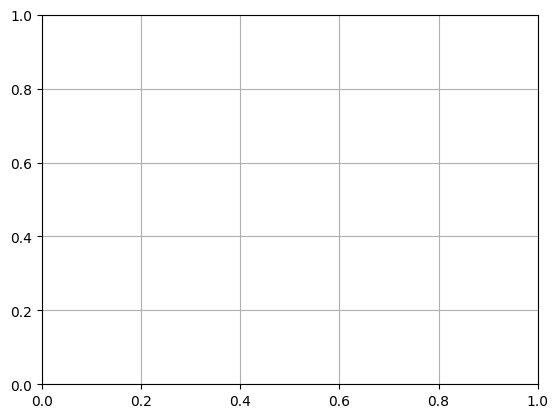

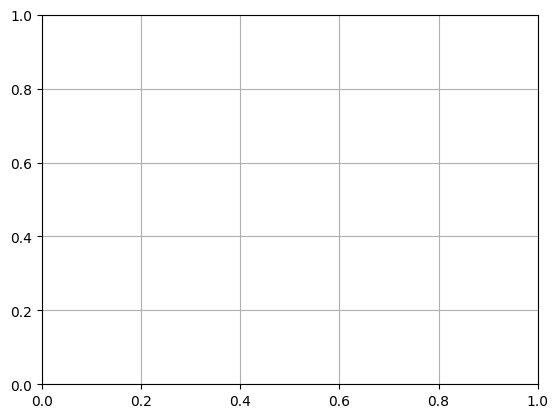

In [27]:
cell_one_round = [282, 184, 264, 184, 180, 115, 184, 184, 174]
ue = [1, 2, 3, 4, 5, 6, 7, 8, 9]
time_divisions = 100
color_map = {
    1: 'red', 
    2: 'green', 
    3: 'blue', 
    4: 'yellow', 
    5: 'purple', 
    6: 'orange', 
    7: 'brown', 
    8: 'pink', 
    9: 'cyan'
}

dp = DisplayPicture(cell_one_round, cell_location)
sub_dp = Sub_DisplayPicture(ue_location)

dp.picture_setting()
dp.plot_cell()

# 部分顯示，並存檔
for time_segment in range(time_divisions) :
    for ue_num in range(9):
        first_time = (time_segment == 0)
        part_cell_one_round = sub_dp.divide_percent(cell_one_round[ue_num], time_divisions)
        x, y, handover = sub_dp.find_ue_location(ue_num, part_cell_one_round[time_segment])
        dp.pre_display_data(ue[ue_num], handover, x ,y, part_cell_one_round[time_segment], color_map, first_time)
    dp.display_part_and_save()

        
# 完整顯示
for ue_num in range(9):
    x, y, handover = sub_dp.find_ue_location(ue_num, cell_one_round[ue_num])
    dp.pre_display_data(ue[ue_num], handover, x ,y, cell_one_round[ue_num], color_map, True)

dp.addition_label()
plt.grid()
plt.show()




ue 1, A3 handover number = 9, model handover number = 0
ue 2, A3 handover number = 6, model handover number = 0
ue 3, A3 handover number = 4, model handover number = 0
ue 4, A3 handover number = 6, model handover number = 0
ue 5, A3 handover number = 4, model handover number = 0
ue 6, A3 handover number = 5, model handover number = 0
ue 7, A3 handover number = 6, model handover number = 0
ue 8, A3 handover number = 8, model handover number = 0
ue 9, A3 handover number = 9, model handover number = 0


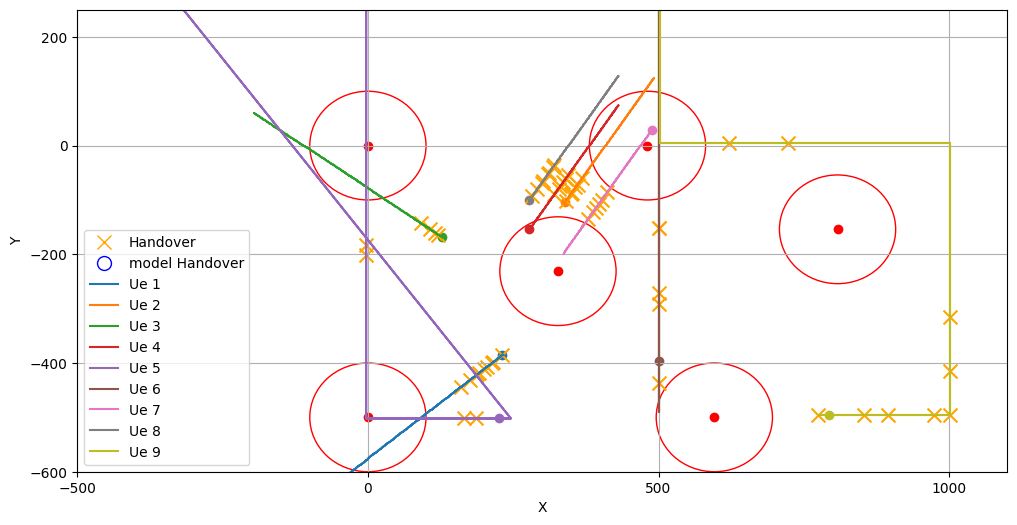

In [ ]:
cell_one_round = [282, 184, 264, 184, 180, 115, 184, 184, 174]
fig, ax = plt.subplots(figsize=(12, 6))

# 設定座標軸標籤
ax.set_xlabel('X')
ax.set_ylabel('Y')

# 設定x軸和y軸範圍
ax.set_xlim(-500, 1100)
ax.set_ylim(-600, 250)

# 設定x軸和y軸格線間隔
ax.set_xticks(np.arange(-500, 1100, 500))
ax.set_yticks(np.arange(-600, 250, 200))


for point in cell_location:
    x = point[0] 
    y = point[1]
    ax.scatter(x, y, color='red')  # 使用红色标记绘制额外的点
    circle = Circle((x, y), 100, edgecolor='red', facecolor='none')  # 绘制半径为100的圆
    ax.add_patch(circle)  # 添加圆形到图中


collect_list = []
for i in range(9):
    # 取出9个UE的X和Y值
    x = []
    y = []
    handover = []
    for k in range(cell_one_round[i]):
        x.append(ue_location[i][1][k])
        y.append(ue_location[i][2][k])
        handover.append(ue_location[i][3][k])
    

    # disply_precent = divide_percent(cell_one_round[i])
    # picture_num = 0
    # for display_sequence in disply_precent:
    #     picture_num = picture_num + 1
    #     sequence_line, = ax.plot(x[:display_sequence], y[:display_sequence], label=f'Ue {i+1}')
    #     plt.show()
    #     file_name = f"ue{i+1}_plot_picture{picture_num}.png"
    #     file_path = os.path.join("picture", file_name)
    #     fig.savefig(file_path, dpi=300)
    #     plt.close()
    #     plt.clf()

    # 繪製連線圖
    line, = ax.plot(x, y, label=f'Ue {i+1}')
    ax.scatter(x[0], y[0], color=line.get_color())  # 加入起始點
    
    A3_handover_num = 0
    model_handover_num = 0

     # 判斷handover_label，並添加紫色點
    for j in range(cell_one_round[i]):
        if handover[j] == 1:
            ax.scatter(x[j], y[j], color='orange', marker='x', s=100)
            A3_handover_num = A3_handover_num + 1
        if handover_store[i]['Handover'][j] == 1 and j > 2:
            ax.scatter(x[j], y[j], facecolors='none', edgecolors='blue', marker='o', s=100)
            model_handover_num = model_handover_num + 1
    print(f"ue {i + 1}, A3 handover number = {A3_handover_num}, model handover number = {model_handover_num}")
    collect_list.append([A3_handover_num, model_handover_num])


    # # 添加圖例
    # ax.legend()
legend_elements = [
    Line2D([0], [0], marker='x', color='orange', label='Handover', markerfacecolor='orange', markersize=10, linestyle='None'),
    Line2D([0], [0], marker='o', color='blue', label='model Handover', markerfacecolor='none', markersize=10, linestyle='None')
]
existing_handles, existing_labels = ax.get_legend_handles_labels()
legend_elements += existing_handles
labels = ['Handover', 'model Handover'] + existing_labels

ax.legend(handles=legend_elements, labels=labels)


plt.grid()    
plt.show()

In [ ]:
print(collect_list)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# 将数据分解为两个单独的列表
heights, widths = zip(*collect_list)

# y轴的位置
y_values = np.arange(9)

# 长条的宽度
bar_width = 0.35

# 创建一个新的figure对象
fig, ax = plt.subplots()

# 创建两个横条图
bar1 = ax.barh(y_values + bar_width, widths, bar_width, label='model handover number')
bar2 = ax.barh(y_values, heights, bar_width, label='A3 handover number')

# 设置y轴的刻度和刻度标签
ax.set_yticks(y_values + bar_width / 2)
labels = ['ue' + str(i+1) for i in range(9)]
ax.set_yticklabels(labels)

# 添加图例
ax.legend()

# 显示图形
plt.show()